In [101]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
data = pd.read_csv('../CMU_SynTraffic_2022/CMU_SynTraffic_2022.csv')

In [60]:
data_real = data[data['Data Source'] == 'Real']
data_smote = data[data['Data Source'] == 'SMOTE']

In [64]:
downsampled_data = data_real

In [22]:
downsampled_data['Application Type'].unique()

array(['audio-streaming', 'browsing', 'chat', 'file-transfer', 'email',
       'p2p', 'video-streaming', 'voip'], dtype=object)

In [53]:
downsampled_data['Application Type'].value_counts()['p2p']

48520

In [41]:
temp = data_smote.loc[data_smote['Application Type'] == 'audio-streaming']
temp

#test = data_smote.groupby('Application Type',group_keys=False)
#data_smote['Application Type'].value_counts

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Idle Mean,Idle Std,Idle Max,Idle Min,Traffic Type,Application Type,Data Source
2217620,17,1766,1,1,34,216,34,34,34.000000,0.000000,...,0,0,8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,audio-streaming,SMOTE
2217621,6,107708863,843,2021,88985,2448274,1161,0,109.542164,223.822591,...,65535,159,20,1.456330e+15,3.537954e+07,1.456330e+15,1.456330e+15,Tor,audio-streaming,SMOTE
2217622,17,603,1,1,42,225,42,42,42.893360,0.000000,...,0,0,8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,audio-streaming,SMOTE
2217623,17,713,1,1,33,345,33,33,33.000000,0.000000,...,0,0,8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,audio-streaming,SMOTE
2217624,17,708,1,1,37,373,37,37,37.000000,0.000000,...,0,0,8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,audio-streaming,SMOTE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2650459,6,62025110,6,4,399,48,180,0,74.860376,96.939316,...,97,2,32,1.433350e+15,3.021771e+07,1.433350e+15,1.433350e+15,VPN,audio-streaming,SMOTE
2650460,17,707,1,1,33,345,33,33,33.000000,0.000000,...,0,0,8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,audio-streaming,SMOTE
2650461,17,48539,1,1,39,936,39,39,39.394865,0.000000,...,0,0,8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,audio-streaming,SMOTE
2650464,17,698,1,1,33,185,33,33,33.000000,0.000000,...,0,0,8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,audio-streaming,SMOTE


In [69]:
for dtype in downsampled_data['Application Type'].unique():
    n = 30000 - downsampled_data['Application Type'].value_counts()[dtype]
    print(dtype, n)
    if(n<0):
        n=0
    temp = data_smote.loc[data_smote['Application Type'] == dtype].sample(n)
    downsampled_data = pd.concat([downsampled_data, temp], ignore_index=True)
    #downsampled_data.concat(temp, ignore_index=True)

audio-streaming 15246
browsing -2808
chat 25049
file-transfer 20659
email 28928
p2p -18520
video-streaming 25291
voip 28535


In [70]:
downsampled_data['Application Type'].value_counts()

p2p                48520
browsing           32808
file-transfer      30000
chat               30000
audio-streaming    30000
email              30000
voip               30000
video-streaming    30000
Name: Application Type, dtype: int64

In [74]:
# downsamples application types with >30000 samples
downsampled_data = downsampled_data.groupby('Application Type').sample(30000)

In [75]:
downsampled_data['Application Type'].value_counts()

file-transfer      30000
chat               30000
audio-streaming    30000
email              30000
voip               30000
browsing           30000
video-streaming    30000
p2p                30000
Name: Application Type, dtype: int64

In [77]:
len(downsampled_data.columns)

65

In [94]:
#downsampled_data = downsampled_data.loc[:,data.columns != 'Data Source']
#downsampled_data = downsampled_data.loc[:,data.columns != 'Traffic Type']
downsampled_data = downsampled_data.drop(columns=['Traffic Type'])


In [95]:
downsampled_data

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Idle Mean,Idle Std,Idle Max,Idle Min,Application Type
3921,17,766,1,1,33,228,33,33,33.000000,0.000000,...,114,0,0,0,8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,audio-streaming
132191,17,662,1,1,41,148,41,41,41.399045,0.000000,...,73,0,0,0,8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,audio-streaming
121623,6,118690739,8616,11551,4788318,11588576,1455,0,337.132202,397.015757,...,632,65535,65535,4445,20,1.456385e+15,2.872017e+07,1.460000e+15,1.456385e+15,audio-streaming
131640,17,585,1,1,34,141,34,34,34.000000,0.000000,...,70,0,0,0,8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,audio-streaming
24553,6,91959542,16,17,1967,5438,1349,0,122.937500,331.668000,...,164,14600,1229,7,20,1.437770e+15,1.954319e+07,1.437770e+15,1.437770e+15,audio-streaming
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238612,17,413666,2,0,44,0,22,22,22.000000,0.000000,...,0,0,0,1,8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,voip
23451,17,411066,2,0,44,0,22,22,22.000000,0.000000,...,0,0,0,1,8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,voip
24239,17,115015979,2,0,410,0,209,201,205.000000,5.656854,...,0,0,0,1,8,1.150160e+08,0.000000e+00,1.150160e+08,1.150160e+08,voip
248739,6,119985092,2899,3731,1301557,1049657,1460,0,447.785563,248.770299,...,154,65535,65535,2305,20,1.437958e+15,3.495135e+07,1.437958e+15,1.440000e+15,voip


In [111]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [103]:
X = downsampled_data.drop(columns=['Application Type'])
Y = downsampled_data['Application Type']

In [105]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=23, stratify=Y)

In [106]:
xgb_model = xgb.XGBClassifier(random_state = 0)
xgb_model.fit(X_train, Y_train)

/home/nalex/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:42:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [108]:
Yp = xgb_model.predict(X_test)

In [109]:
accuracy_score(Y_test,Yp)

0.948875

In [129]:
f1_score(Y_test,Yp,average='macro')

0.9489744828097811

<AxesSubplot:>

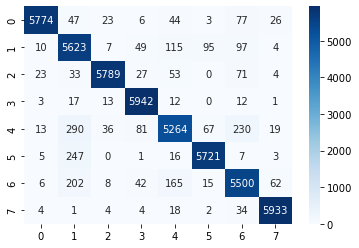

In [127]:
cm = confusion_matrix(Y_test, Yp)
sns.heatmap(cm, annot = True, cmap = 'Blues', fmt='g')

In [102]:
#xgb_model = xgb.train(params, train, epochs, evallist,evals_result=store,verbose_eval=100)


array(['audio-streaming', 'audio-streaming', 'audio-streaming', ...,
       'voip', 'voip', 'voip'], dtype=object)